# Training a Bayesian Neural Network for Computer Model Emulation

### Import necessary libraries 

In [2]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [3]:
# suppress some theano compilation errors with MacOSX clang compiler
import theano
# CF added (https://stackoverflow.com/questions/51238578/error-non-constant-expression-cannot-be-narrowed-from-type-npy-intp-to-int)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T

In [4]:
#prepare the directories for model design and outputs
#run this cell only once, or else it will hang!
#! sh prepare.sh

### Loading Computer Model inputs and outputs

In [5]:
from calculations_load import *
from configurations import *

system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#X = design # include all parameters
feature_cols = ['norm', 'trento_p']
n_features = len(feature_cols)

X = design[feature_cols]

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)
obs = 'dNch_deta' #choose the observable we want to emulate

#n_cent = 1 # choose the number of centrality bins 

cent = 5 # choose the cent bin 
Y = []
for pt in range(npt):
    Y.append( trimmed_model_data[system_str][pt, idf][obs]['mean'][cent:cent+1] ) #all cent bins

#Y = np.array(Y).reshape(-1, 1)
Y = np.array(Y)

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'main_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/main', 'validation_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/validation', 'main_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/main.dat', 'validation_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/validation.dat', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 32

In [6]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 2)
Y.shape : (485, 1)


## Splitting the inputs and outputs into a training and testing set

Then, scaling all of the inputs and outputs to (0, 1)

In [7]:
X = X.astype(floatX)
Y = Y.astype(floatX)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1)

X_scaler = StandardScaler().fit(X_train)
Y_scaler = StandardScaler().fit(Y_train)
#X_scaler = MinMaxScaler().fit(X_train)
#Y_scaler = MinMaxScaler().fit(Y_train)

X_train_sc = X_scaler.transform(X_train)
X_test_sc = X_scaler.transform(X_test)

Y_train_sc = Y_scaler.transform(Y_train)
Y_test_sc = Y_scaler.transform(Y_test)

In [8]:
#NECESSARY IF Y HAS A SINGLE FEATURE
Y_train_sc = Y_train_sc.reshape(Y_train_sc.shape[0])
Y_test_sc = Y_test_sc.reshape(Y_test_sc.shape[0])

In [36]:
# Find how many of testing data fall outside the range -1 to 1.
out_of_range_y_test=np.sum([1 for yy in Y_test_sc if abs(yy)>1])
out_of_range_x_test=np.sum([1 for xx in X_test_sc.flatten() if abs(xx)>1])
print(f'There are {out_of_range_y_test} entries in the  output test data and \
{out_of_range_x_test} entries in input test data which are out of range when \nscaled')

There are 13 entries in the  output test data and 48 entries in input test data which are out of range when 
scaled


### Plot a feature matrix of how our inputs correlate with outputs

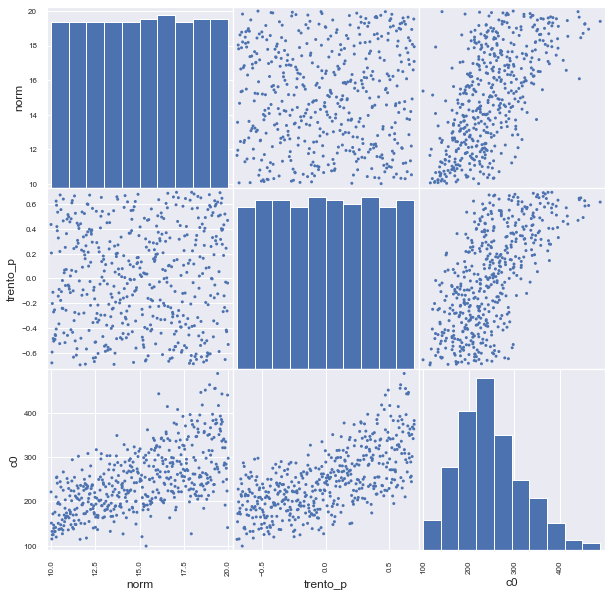

In [9]:
#df_Y = pd.DataFrame(data=Y, columns=["c0", "c1", "c2", "c3"])
df_X = pd.DataFrame(data=X[feature_cols].values, columns=feature_cols) #need to line up the rows (missing data)
df_Y = pd.DataFrame(data=Y, columns=["c0"])
df_X_Y = df_X.join(df_Y) 
scatter_matrix(df_X_Y, figsize = (10,10), alpha=1)
plt.show()

### The cell below constructs the Bayesian neural network
I'm not sure yet how to best choose the priors for the weights - overfitting should probably be a primary concern

In [57]:
sigma_w_i = 1 #how should we fix this prior ???
sigma_pred = 3.0 #how should we fix this prior ???

#whether the non-linear activation functions are turned on ...
build_linear_net = False

def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)
    # Initialize random biases in each layer
    init_b_1 = np.random.randn(n_hidden).astype(floatX)
    init_b_2 = np.random.randn(n_hidden).astype(floatX)
    init_b_out = np.random.randn(1).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train_sc)
        ann_output = pm.Data('ann_output', Y_train_sc)
        
        sigma_w = pm.HalfNormal('sigma_w', sigma=1,testval=sigma_w_i)
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', mu=0, sigma=sigma_w, shape=(X.shape[1], n_hidden), testval=init_1)
        # Bias at 1st hidden layer
        bias_1 = pm.Normal('b_1', mu=0, sigma=sigma_w, shape=(n_hidden), testval=init_b_1)

        # Weights from 1st hidden to 2nd hidden layer
        weights_1_2 = pm.Normal('w_1_2', mu=0, sigma=sigma_w, shape=(n_hidden, n_hidden), testval=init_2)
        # Bias at 2nd hidden layer
        bias_2 = pm.Normal('b_2', mu=0, sigma=sigma_w, shape=(n_hidden), testval=init_b_2)
        
        # Weights from 2nd hidden layer to output
        weights_2_out = pm.Normal('w_2_out', mu=0, sigma=sigma_w, shape=(n_hidden,), testval=init_out)
        # Bias at output hidden layer
        bias_out = pm.Normal('b_out', mu=0, sigma=sigma_w, shape=(1), testval=init_b_out)
        
        if build_linear_net:
            act_1 = pm.math.dot(ann_input, weights_in_1) + bias_1
            act_2 = pm.math.dot(act_1, weights_1_2) + bias_2
            act_out = pm.math.dot(act_2, weights_2_out) + bias_out
        
        else:
            # Build neural-network using tanh activation function
            act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + bias_1)
            act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + bias_2)
            act_out = pm.math.dot(act_2, weights_2_out) + bias_out
            
        #sigma_pred=pm.Normal('sigma_pred',mu=0)
        sd = pm.HalfNormal('sd', sigma=1,testval=sigma_pred)
        out = pm.Normal('out', mu=act_out, sigma=sd, observed=ann_output)
        
    return neural_network

neural_network = construct_nn(X_train_sc, Y_train_sc)

In [58]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

### The cell below uses ADVI to train the network weights

In [59]:
%%time

with neural_network:
    #inference = pm.ADVI() #mean field, no correlations 
    method = 'fullrank_advi' #includes correlation terms in trial functions
    approx = pm.fit(n=30000, method=method)

Average Loss = 352.59: 100%|██████████| 30000/30000 [00:30<00:00, 988.22it/s] 
Finished [100%]: Average Loss = 352.63


CPU times: user 1min 58s, sys: 4.6 s, total: 2min 3s
Wall time: 46.5 s


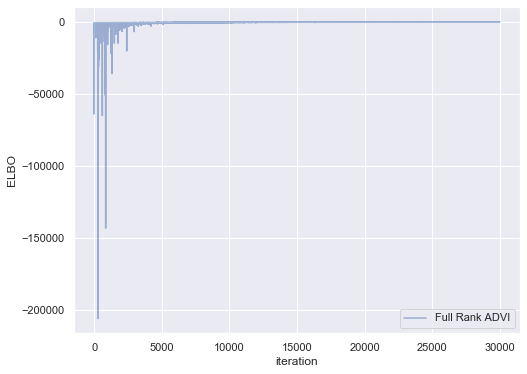

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(-approx.hist, label='Full Rank ADVI', alpha=.5)
ax.legend()
ax.set_ylabel('ELBO')
ax.set_xlabel('iteration')
plt.tight_layout;

### Trace Plot of Inference

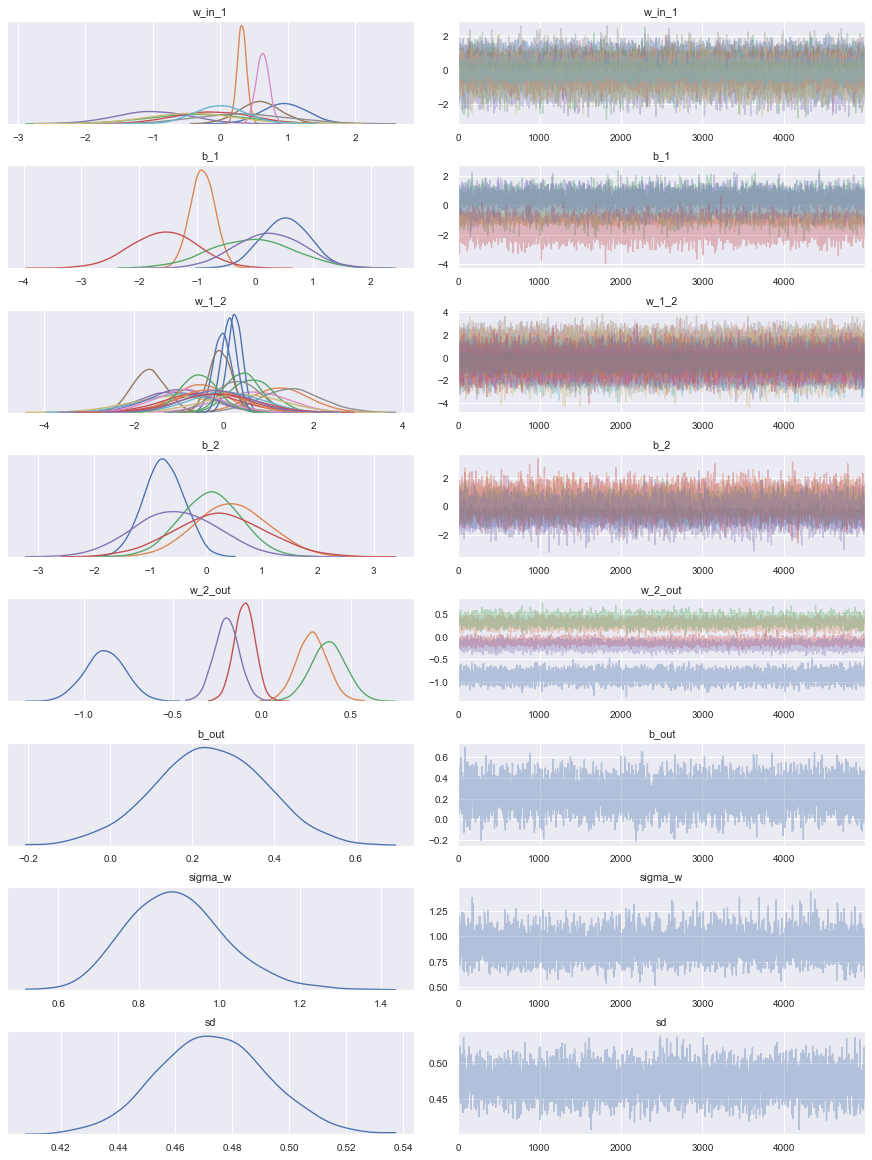

In [61]:
trace = approx.sample(draws=5000)
pm.traceplot(trace)
plt.show()

### Let's ask the network to generate predictions on a grid

In [62]:
#X_grid = np.linspace(-2, 2, 300).reshape(-1, n_features)
x1_grid = np.linspace(-2, 2, 100)
#x2_grid = np.zeros(100)
x2_grid = np.linspace(-2, 2, 100)
X_grid = np.column_stack((x1_grid, x2_grid))

with neural_network:
    pm.set_data({'ann_input': X_grid})
    pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:11<00:00, 90.58it/s]


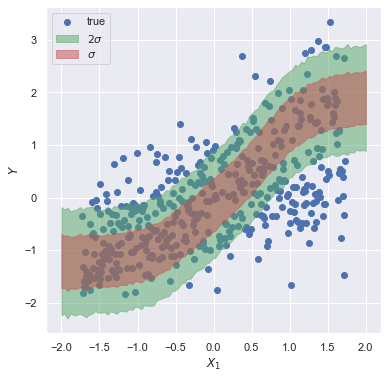

In [64]:
pred_mean = pred['out'].mean(axis=0)
pred_std  = pred['out'].std(axis=0)

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(x=X_train_sc[:, 0], y=Y_train_sc, label='true')
plt.fill_between(x1_grid, pred_mean - 2.*pred_std, pred_mean + 2.*pred_std, 
                 label=r'$2\sigma$', color='g', alpha=0.5)
plt.fill_between(x1_grid, pred_mean - pred_std, pred_mean + pred_std, 
                 label=r'$\sigma$', color='r', alpha=0.5)
plt.legend()
plt.xlabel(r"$X_1$")
plt.ylabel(r"$Y$")
plt.show()

In [65]:
#X_grid = np.linspace(-2, 2, 300).reshape(-1, n_features)
x1_grid = np.linspace(-2, 2, 100)
x2_grid = np.linspace(-2, 2, 100)
X_grid = np.column_stack((x1_grid, x2_grid))

with neural_network:
    pm.set_data({'ann_input': X_grid})
    pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:10<00:00, 92.68it/s]


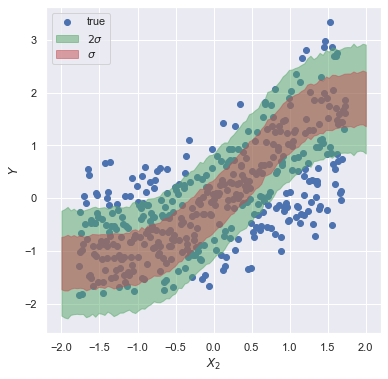

In [66]:
pred_mean = pred['out'].mean(axis=0)
pred_std  = pred['out'].std(axis=0)

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(x=X_train_sc[:, 1], y=Y_train_sc, label='true')
plt.fill_between(x2_grid, pred_mean - 2.*pred_std, pred_mean + 2.*pred_std, 
                 label=r'$2\sigma$', color='g', alpha=0.5)
plt.fill_between(x2_grid, pred_mean - pred_std, pred_mean + pred_std, 
                 label=r'$\sigma$', color='r', alpha=0.5)
plt.legend()
plt.xlabel(r"$X_2$")
plt.ylabel(r"$Y$")
plt.show()

### I don't know what the cells below are doing yet...

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). 
1. We can use `sample_posterior_predictive() <../api/inference.rst>`__ to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).
1. It is better to get the node directly and build theano graph using our approximation (approx.sample_node) , we get a lot of speed up

In [87]:
type(neural_network.out.distribution)

pymc3.distributions.continuous.Normal

In [99]:
# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train_sc[:10])
n.tag.test_value = 100
_sample_pred = approx.sample_node(neural_network.out.distribution.mu,
                                          size=n,
                                          more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba= theano.function([x, n], _sample_pred)

In [100]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [101]:
ppc = sample_proba(grid_2d ,500)

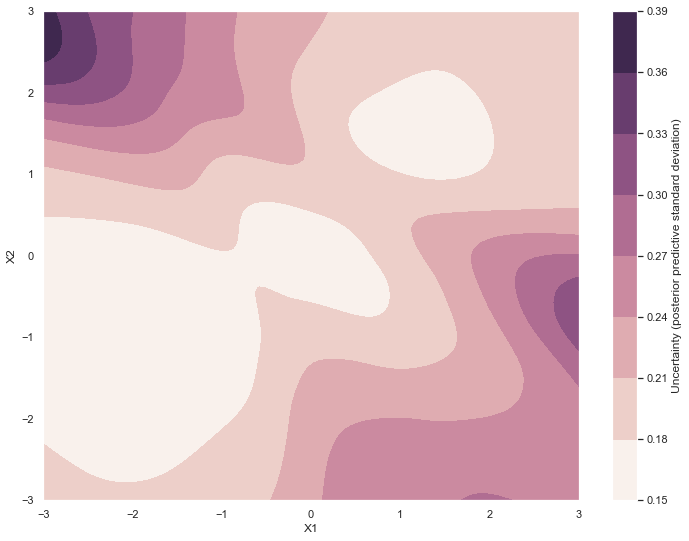

In [103]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
#ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
#ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [ ]:
%timeit production_step1()

In [ ]:
%timeit production_step2()

## Acknowledgements

This notebook is very much inspired by a blog post written by Thomas Wiecki (and updated by Maxim Kochurov). The
original posts are available [here](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) and [here](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html).

This example uses the [PyMC3](https://docs.pymc.io/) package for probabilistic programming, and relies in particular on the [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi) implementation by [Taku Yoshioka](https://github.com/taku-y).